In [1]:
# Import des dépendances
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
import pandas as pd
import scipy as sp
import numpy as np
import calendar

In [2]:
## Définition de plusieurs fonctions réutilisées par la suite

# Définition d'une fonctions permettant de récupérer la prochaine valeur existante
def getNextCorrectValue(df, rowIndex, columnIndex):
    nextValue = df.iloc[(rowIndex + 1), columnIndex]
    if np.isnan(nextValue):
        return getNextCorrectValue(df, rowIndex+2, columnIndex)
    else:
        return nextValue


# Définition d'une fonctions permettant de récupérer la précédente valeur existante
def getPreviousCorrectValue(df, rowIndex, columnIndex):
    nextValue = df.iloc[(rowIndex-1), columnIndex]
    if np.isnan(nextValue):
        return getNextCorrectValue(df, rowIndex-2, columnIndex)
    else:
        return nextValue


# Définition d'une fonction permettant de calculer la moyenne par tableau de nombre
def getAveragePerArray(arrayOfArray):
    average_per_array=[]

    # Calcul de la moyenne par mois

    for index in range(len(arrayOfArray)):
        average_per_array.append(np.average(arrayOfArray[index]))
    
    return average_per_array


# Définition d'une fonction permettant de calculer l'écart type par tableau de nombre
def getStandardDeviationPerArray(arrayOfArray):
    standard_deviation_per_array=[]
    
    # Calcul de l'écart type de température par mois
    
    for index in range(len(arrayOfArray)):
        standard_deviation_per_array.append(np.std(arrayOfArray[index]))
        
    return standard_deviation_per_array


# Définition d'une fonction qui trouve le minimum et le maxium dans une array par array
def getMinAndMaxPerArray(arrayOfArray):
    
    min_per_array=[]
    max_per_array=[]
    
    # Détermination du minimum et maximum par array
    for index in range(len(arrayOfArray)):
        min_per_array.append(min(arrayOfArray[index]))
        max_per_array.append(max(arrayOfArray[index]))
    
    return min_per_array, max_per_array

# Retourne un array avec les valeurs centrées
def getArrayOfCenterValue(array, index, limit):
    return array[(index - (limit if index - limit > 0 else 0)):(index + (limit if index + (limit < len(array) - 1) else len(array) - 1))]

# Définition d'une lambda permettant de mettre à plat une array d'array
flatten = lambda t: [item for sublist in t for item in sublist]

# Définition d'une lambda de diviser une liste par une autre
calculateDeviation = lambda list1, list2 : [abs(np.round(i / j, 3)) for i, j in zip(list1, list2)]

# Définition d'une fonction qui permet d'afficher un pointeur
class SnaptoCursor(object):
    def __init__(self, ax, x, y):
        self.ax = ax
        self.ly = ax.axvline(color='k', alpha=0.2)  # the vert line
        self.marker, = ax.plot([0],[0], marker="o", color="crimson", zorder=3) 
        self.x = x
        self.y = y
        self.txt = ax.text(0.7, 0.9, '')

    def mouse_move(self, event):
        if not event.inaxes: return
        x, y = event.xdata, event.ydata
        indx = np.searchsorted(self.x, [x])[0]
        x = self.x[indx]
        y = self.y[indx]
        self.ly.set_xdata(x)
        self.marker.set_data([x],[y])
        self.txt.set_text('%1.2f°C (day %1d)' % (y, x))
        self.txt.set_position((x,y))
        self.ax.figure.canvas.draw_idle()



In [3]:
# Définition d'une tableau contenant les températures par mois et par set de données
temperatures=[]

# Définition d'une tableau contenant la moyenne des températures par mois et par set de données
temperatures_averages=[]

# Définition d'une tableau contenant l'écart type des températures par mois et par set de données
temperatures_standard_deviation=[]

# Définition d'une tableau contenant le minimum et le maximum des températures par mois et par set de données
temperatures_min_per_month=[]
temperatures_max_per_month=[]

### Traitement sur le fichier Climat.xlsx avec la feuille SI ###

In [4]:
## Chargement de la page "SI" du fichier "Climat.xlsx"

current_si = 0
si_ok = pd.read_excel("/home/jovyan/work/data/Climat.xlsx", sheet_name=0)

In [5]:
## Récupération des températures depuis l'excel pour le "SI"

temperature_si = []

for column in range(3, 15):
    month_temperature=[]
    for row in range(3, 34):
        temperature_value = si_ok.iloc[row, column]
        if(not np.isnan(temperature_value)):
            month_temperature.append(temperature_value)
    temperature_si.append(month_temperature)
    
# On sauvegarde les données de ce set de données qui aura l'index 0
temperatures.append(temperature_si)

In [6]:
# Calcul des moyennes des températures
temperatures_averages.append(getAveragePerArray(temperatures[current_si]))

# Calcul des écarts-types des températures
temperatures_standard_deviation.append(getStandardDeviationPerArray(temperatures[current_si]))

# Calcul des min et max des températures par mois
min_per_array, max_per_array = getMinAndMaxPerArray(temperatures[current_si])
temperatures_min_per_month.append(min_per_array)
temperatures_max_per_month.append(max_per_array)
print("Min temp {!s} and max temp {!s}".format(min(min_per_array), max(max_per_array)))

Min temp -23 and max temp 26


<IPython.core.display.Javascript object>


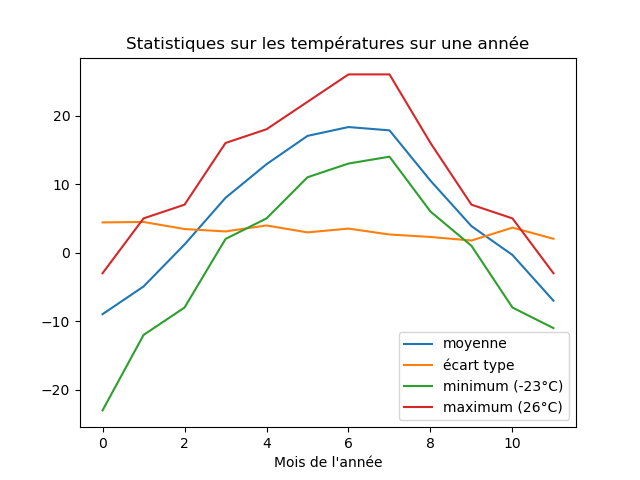

In [7]:
# Affichages des moyennes, des écarts-types et des min-max par mois
# dans un schéma pour que ce soit visuel

%matplotlib notebook

plot = plt.figure(0)
plt.plot(temperatures_averages[current_si], label = "moyenne")
plt.plot(temperatures_standard_deviation[current_si], label = "écart type")
plt.plot(temperatures_min_per_month[current_si], label = "minimum (" + str(min(temperatures_min_per_month[current_si])) + "°C)")
plt.plot(temperatures_max_per_month[current_si], label = "maximum (" + str(max(temperatures_max_per_month[current_si])) + "°C)")
plt.xlabel("Mois de l'année")
plt.title("Statistiques sur les températures sur une année")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


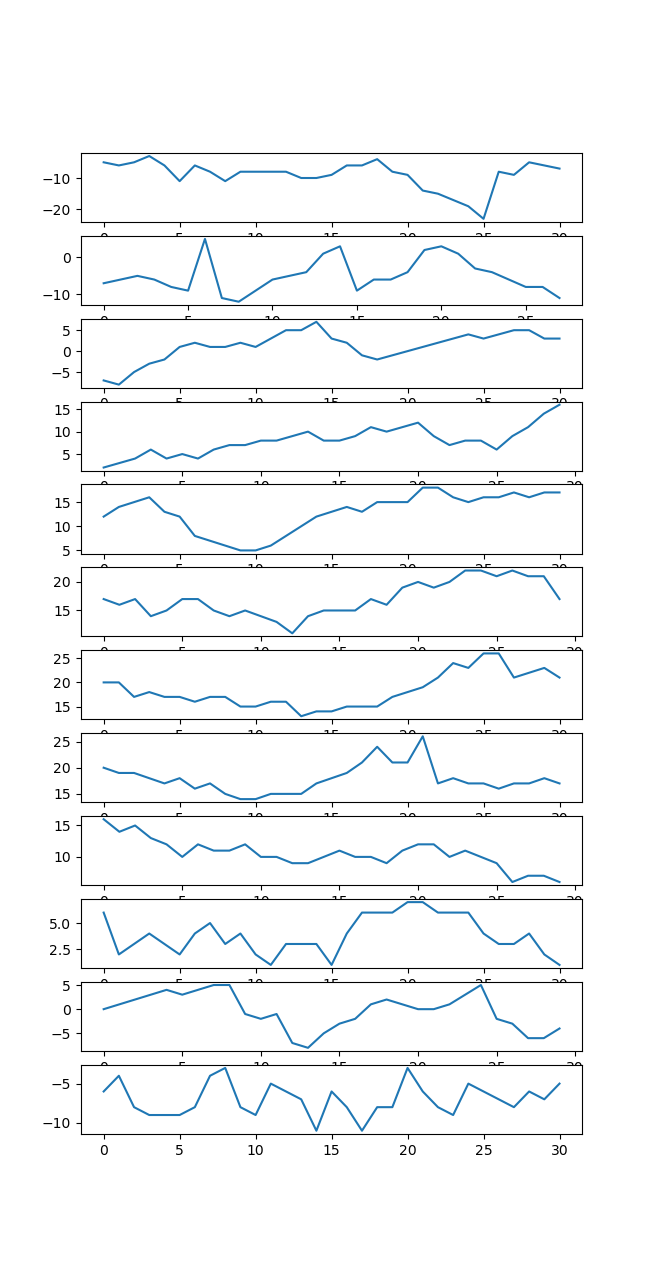

In [8]:
# Affichage de la température par mois via 1 figure

%matplotlib notebook

fig, axs = plt.subplots(len(temperatures[current_si]))

for month in range(len(temperatures[current_si])):
    axs[month].plot(temperatures[current_si][month])
    plt.show()

<IPython.core.display.Javascript object>


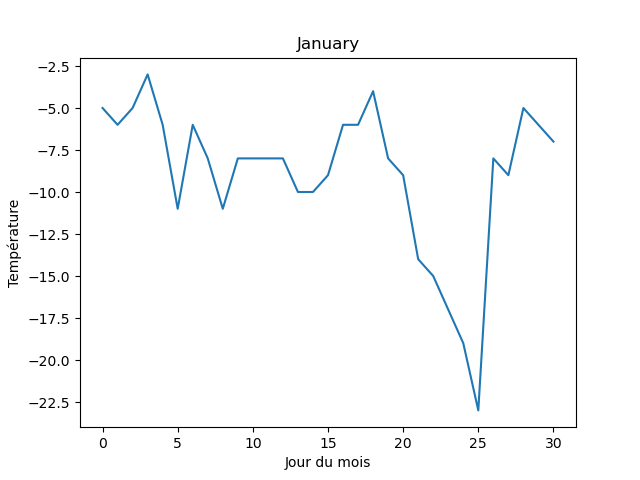

<IPython.core.display.Javascript object>


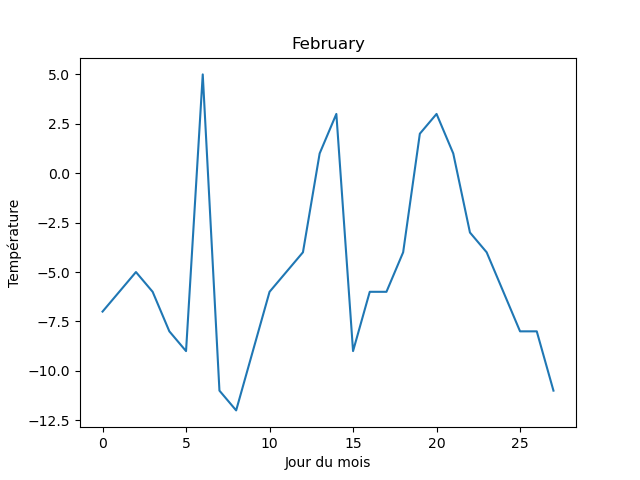

<IPython.core.display.Javascript object>


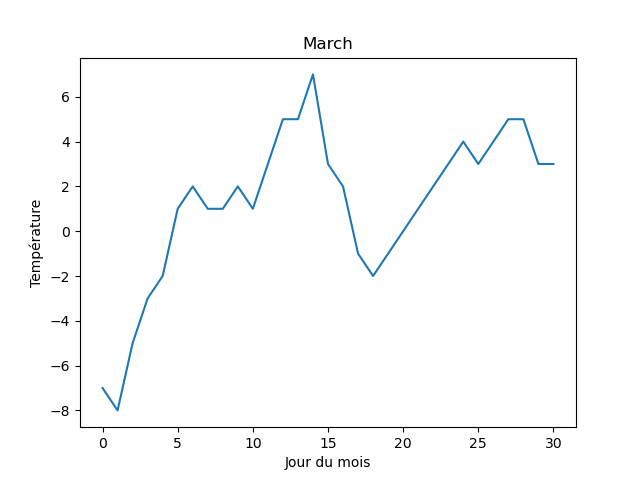

<IPython.core.display.Javascript object>


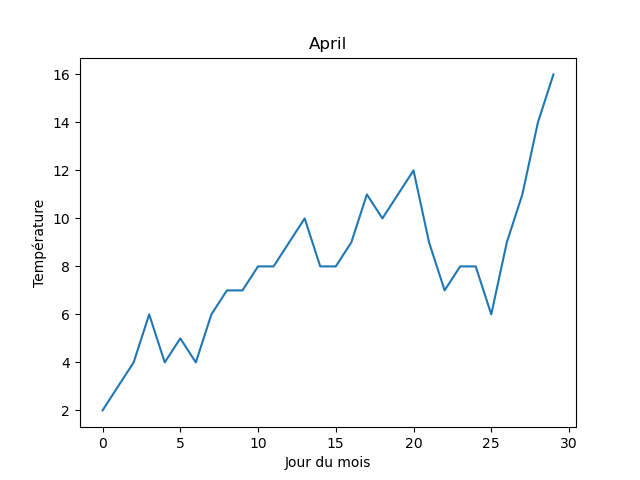

<IPython.core.display.Javascript object>


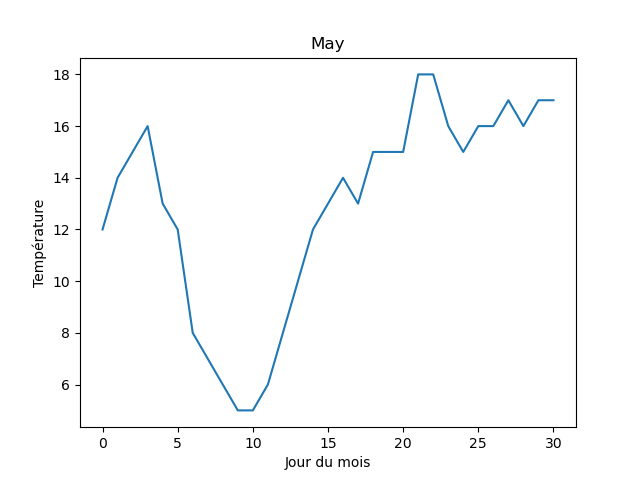

<IPython.core.display.Javascript object>


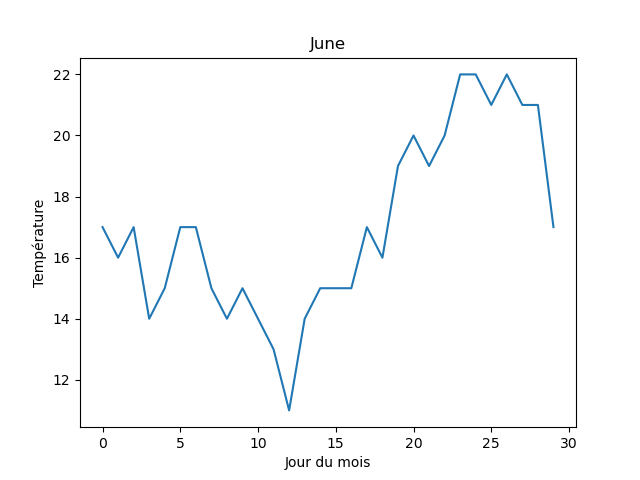

<IPython.core.display.Javascript object>


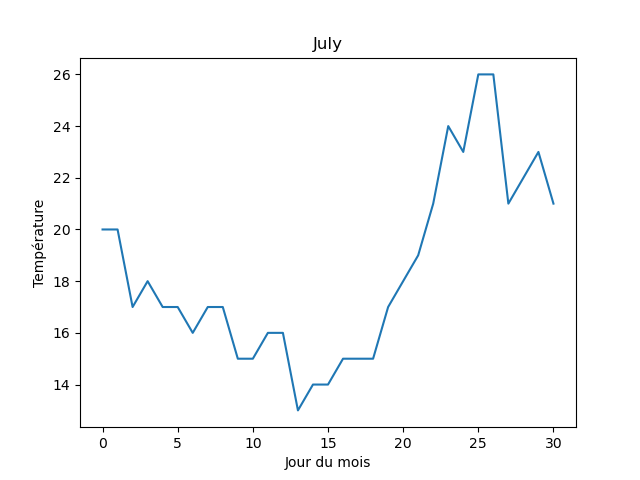

<IPython.core.display.Javascript object>


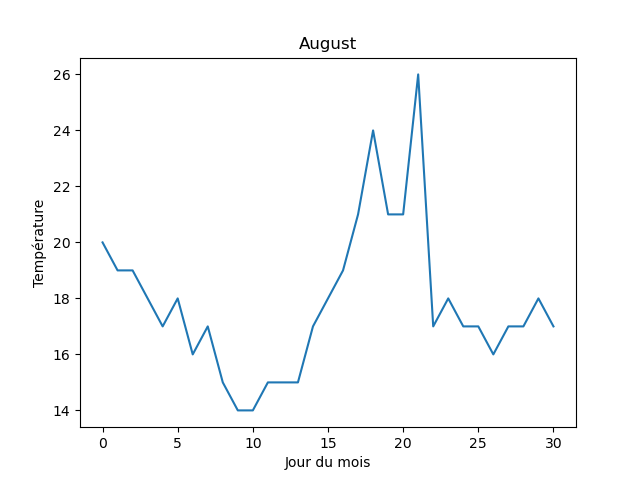

<IPython.core.display.Javascript object>


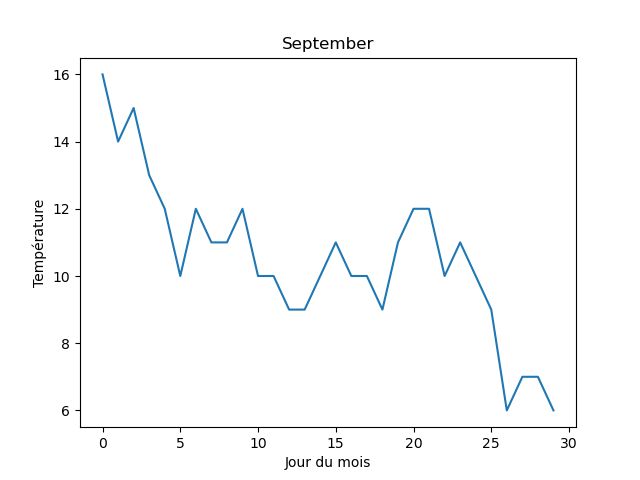

<IPython.core.display.Javascript object>


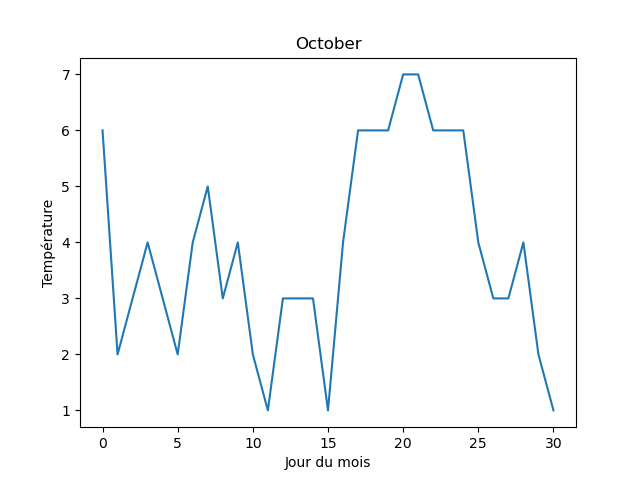

<IPython.core.display.Javascript object>


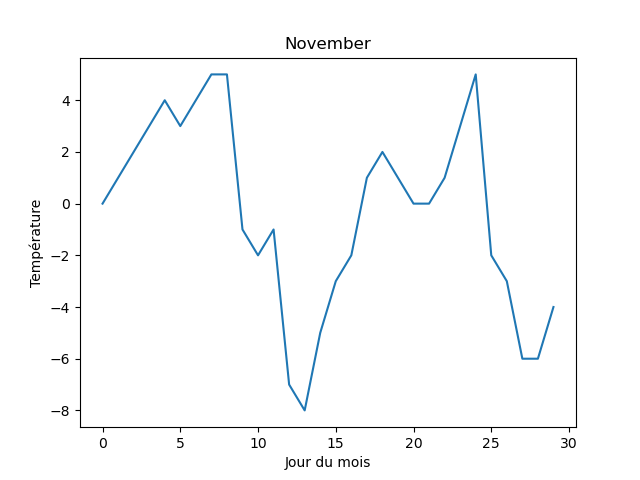

<IPython.core.display.Javascript object>


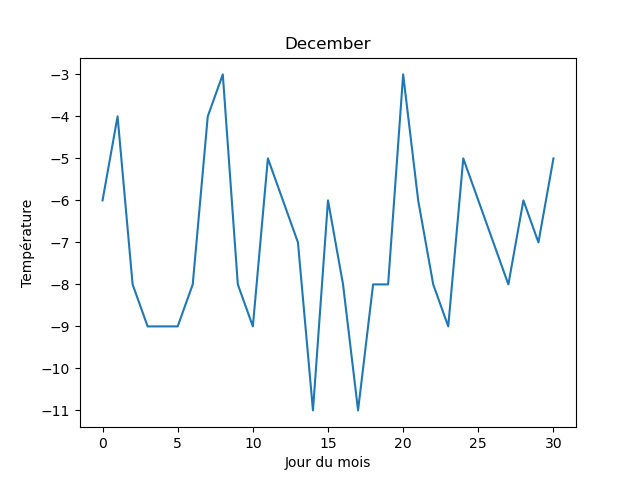

In [9]:
# Affichage de la température par mois via 12 figures

%matplotlib notebook

for month in range(len(temperatures[current_si])):
    plot = plt.figure(month)
    plt.title(calendar.month_name[month + 1])
    plt.plot(temperatures[current_si][month])
    plt.xlabel("Jour du mois")
    plt.ylabel("Température")

plt.show()

<IPython.core.display.Javascript object>


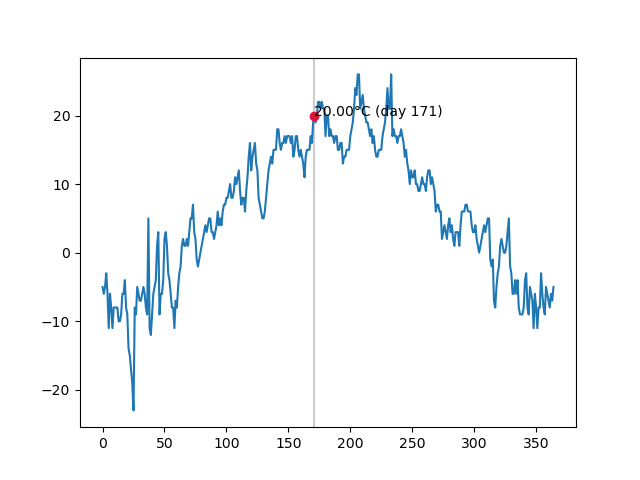

In [12]:
# Affichage de la température à l'année avec un curseur pour lire les valeurs

fig_range = np.arange(0, 365, 1)
fig, ax = plt.subplots()

cursor = SnaptoCursor(ax, fig_range, flatten(temperatures[current_si]))
cid =  plt.connect('motion_notify_event', cursor.mouse_move)

ax.plot(fig_range, flatten(temperatures[current_si]),)
plt.show()

<IPython.core.display.Javascript object>


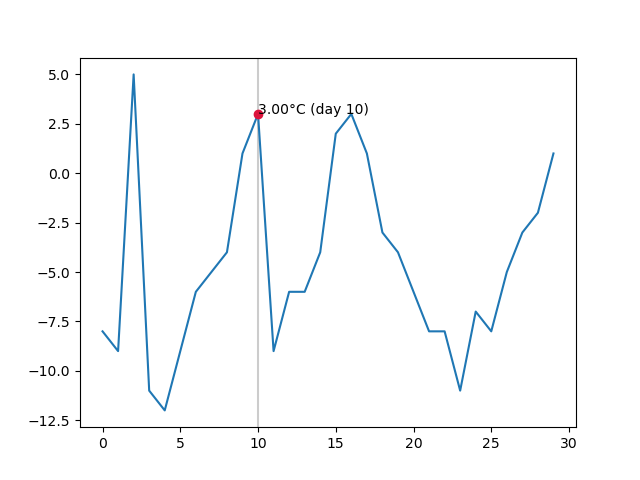

In [13]:
# Affichage de la température à l'année avec une valeur centrée

fig_range = np.arange(0, 30, 1)
fig, ax = plt.subplots()

arrayOfTemperature = getArrayOfCenterValue(flatten(temperatures[current_si]), 50, 15)
cursor = SnaptoCursor(ax, fig_range, arrayOfTemperature)
cid =  plt.connect('motion_notify_event', cursor.mouse_move)

ax.plot(fig_range, arrayOfTemperature,)
plt.show()

### Traitement sur le fichier Climat.xlsx avec la feuille SI - Erreur ###

In [14]:
## Chargement de la page "SI - Erreur" du fichier "Climat.xlsx"

current_si += 1
si_erreur = pd.read_excel("/home/jovyan/work/data/Climat.xlsx", sheet_name=1)

In [15]:
## Récupération des températures depuis l'excel pour le "SI erreur"

temperature_si = []

for column in range(3, 15):
    month_temperature=[]
    for row in range(3, 34):
        temperature_value = si_erreur.iloc[row, column]
        
        # Si le type de la température n'est pas cohérent alors on fait la moyenne 
        # de la température précédente et suivante ayant au moins une valeur correcte
        if(type(temperature_value) is str):
            temperature_value = np.average([getNextCorrectValue(si_erreur, row, column), getPreviousCorrectValue(si_erreur, row, column)])

        # Si la valeur n'est pas nulle (pour un mois plus court comme février)
        # alors on ne prend pas cette valeur en compte
        if(not np.isnan((temperature_value))):
            month_temperature.append(temperature_value)

    temperature_si.append(month_temperature)

# On sauvegarde les données de ce set de données qui aura l'index 1
temperatures.append(temperature_si)

In [16]:
# Calcul des moyennes des températures
temperatures_averages.append(getAveragePerArray(temperatures[current_si]))

# Calcul des écarts-types des températures
temperatures_standard_deviation.append(getStandardDeviationPerArray(temperatures[current_si]))

In [17]:
# Maintenant que nous avons calculé un premier jet de nos moyennes et de nos écarts-types, 
# nous allons les utiliser pour trouver les nombres "atypiques". Ces nombres seront ensuite
# remplacés par la moyenne de la valeur précédente et suivante dans le tableau.

def replaceTemperatureByAverage(temperatures, current_si, month, day_of_month):
    print("to replace, month="+str(month)+", day="+str(day_of_month)+", temp="+str(temperatures[current_si][month][day_of_month])+"")
    # On calcul la nouvelle valeur qui est la moyenne de la suivante et de la précédente
    new_temperature = int(np.average([temperatures[current_si][month][day_of_month - 1], temperatures[current_si][month][day_of_month + 1]]))
    temperatures[current_si][month][day_of_month] = new_temperature

def getPreviousValueOfArray(arrayOfArray, arrayIndex, initValueIndex):
    if(initValueIndex == 0):
        arrayIndex -= 1
        if arrayIndex < 0:
            return None
        else:
            return arrayOfArray[arrayIndex][len(arrayOfArray[arrayIndex]) - 1]
    return arrayOfArray[arrayIndex][initValueIndex - 1]

def getNextValueOfArray(arrayOfArray, arrayIndex, initValueIndex):
    if(initValueIndex == len(arrayOfArray[arrayIndex]) - 1):
        arrayIndex += 1
        if arrayIndex >= len(arrayOfArray):
            return None
        else:
            return arrayOfArray[arrayIndex][0]
    return arrayOfArray[arrayIndex][initValueIndex + 1]

for month in range(len(temperatures[current_si])):
    # On considère qu'une valeur est atypique si elle n'est pas dans l'intervalle 
    # [(moyenne - écart type du mois) ; (moyenne + écart type du mois)]
    month_std = temperatures_standard_deviation[current_si][month]
    min_interval = temperatures_averages[current_si][month] - month_std
    max_interval = temperatures_averages[current_si][month] + month_std
    
    month_len = len(temperatures[current_si][month])
    for day_of_month in range(month_len):
        temperature_of_day = temperatures[current_si][month][day_of_month]
        if temperature_of_day < min_interval or temperature_of_day > max_interval:
            
            # Pour savoir si la valeur est cohérente, on vérifie l'écart entre la valeur précédente et/ou suivante
            # avec la température actulle ne dépasse par l'écart type
            previous_temperature = getPreviousValueOfArray(temperatures[current_si], month, day_of_month)
            next_temperature = getNextValueOfArray(temperatures[current_si], month, day_of_month)
            
            if(previous_temperature != None and next_temperature != None):
                if np.abs(temperature_of_day - previous_temperature) > month_std and np.abs(temperature_of_day - next_temperature) > month_std:
                    replaceTemperatureByAverage(temperatures, current_si, month, day_of_month)
            elif previous_temperature != None:
                if np.abs(temperature_of_day - previous_temperature) > month_std:
                    replaceTemperatureByAverage(temperatures, current_si, month, day_of_month)
            elif next_temperature != None:
                if np.abs(temperature_of_day - next_temperature) > month_std:
                    replaceTemperatureByAverage(temperatures, current_si, month, day_of_month)

to replace, month=1, day=6, temp=5
to replace, month=6, day=15, temp=-6
to replace, month=7, day=14, temp=48
to replace, month=9, day=15, temp=1
to replace, month=11, day=20, temp=-33


In [18]:
# Calcul des moyennes des températures
temperatures_averages[current_si] = getAveragePerArray(temperatures[current_si])

# Calcul des écarts-types des températures
temperatures_standard_deviation[current_si] = getStandardDeviationPerArray(temperatures[current_si])

# Calcul des min et max des températures par mois
min_per_array, max_per_array = getMinAndMaxPerArray(temperatures[current_si])
temperatures_min_per_month.append(min_per_array)
temperatures_max_per_month.append(max_per_array)
print("Min temp {!s} and max temp {!s}".format(min(min_per_array), max(max_per_array)))

Min temp -23 and max temp 26


<IPython.core.display.Javascript object>


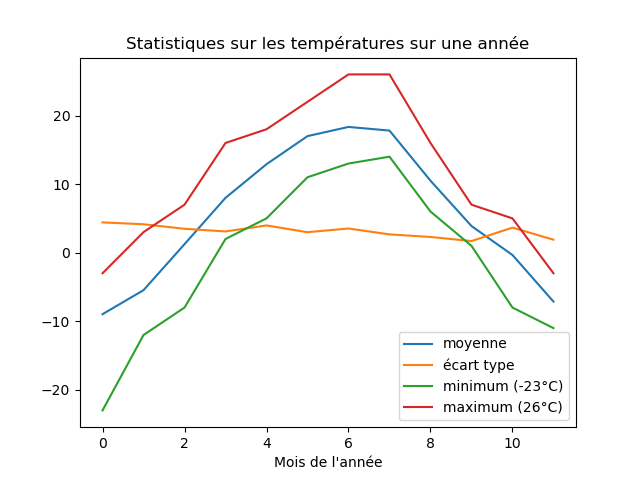

In [19]:
# Affichages des moyennes, des écarts-types et des min-max par mois
# dans un schéma pour que ce soit visuel

%matplotlib notebook

plot = plt.figure(0)
plt.plot(temperatures_averages[current_si], label = "moyenne")
plt.plot(temperatures_standard_deviation[current_si], label = "écart type")
plt.plot(temperatures_min_per_month[current_si], label = "minimum (" + str(min(temperatures_min_per_month[current_si])) + "°C)")
plt.plot(temperatures_max_per_month[current_si], label = "maximum (" + str(max(temperatures_max_per_month[current_si])) + "°C)")
plt.xlabel("Mois de l'année")
plt.title("Statistiques sur les températures sur une année")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


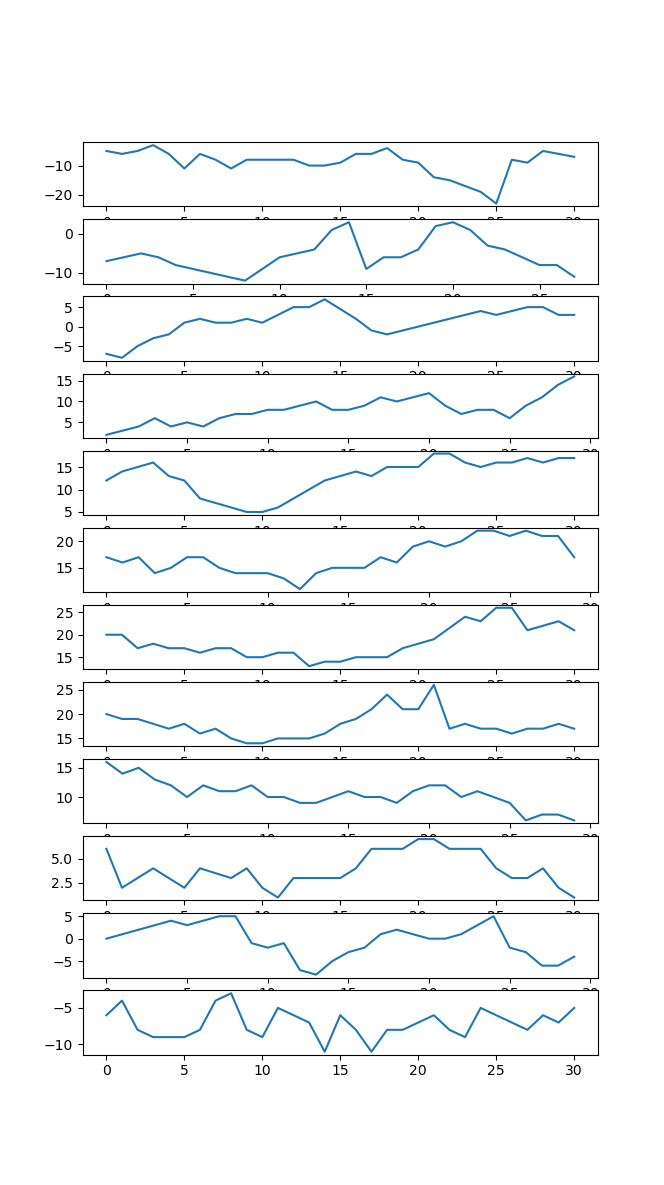

In [20]:
# Affichage de la température par mois via 1 figure

%matplotlib notebook

fig, axs = plt.subplots(len(temperatures[current_si]))

for month in range(len(temperatures[current_si])):
    axs[month].plot(temperatures[current_si][month])
    plt.show()

<IPython.core.display.Javascript object>


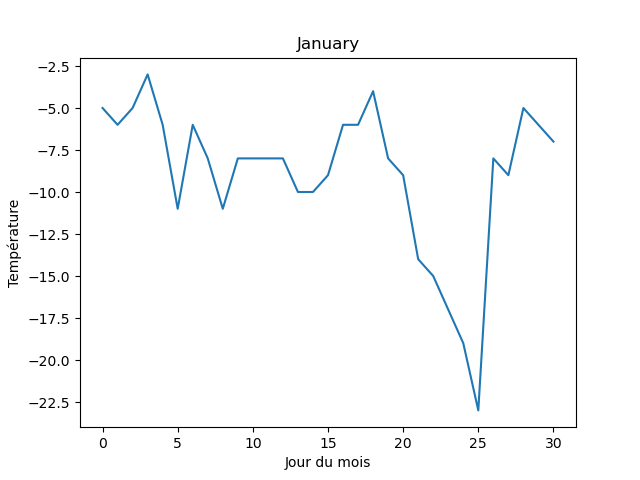

<IPython.core.display.Javascript object>


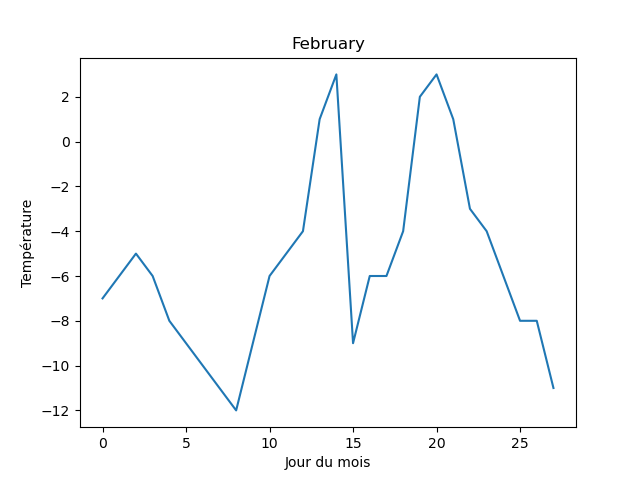

<IPython.core.display.Javascript object>


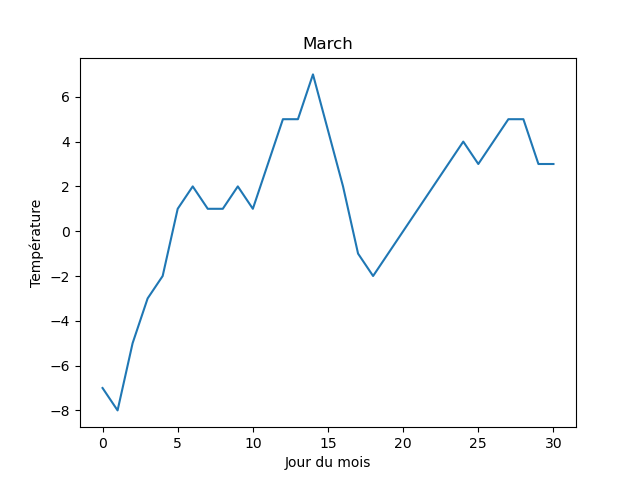

<IPython.core.display.Javascript object>


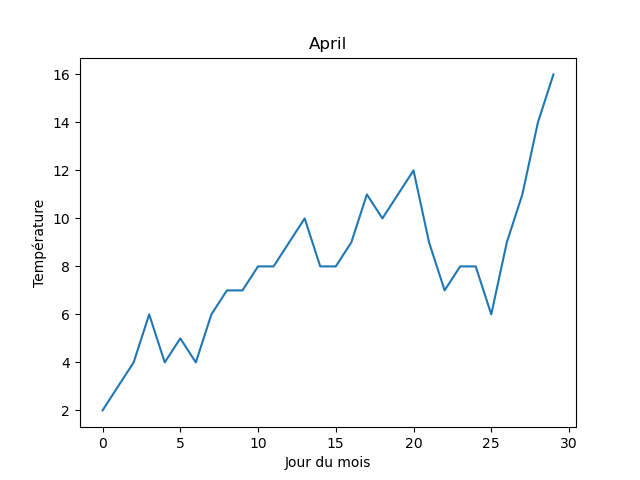

<IPython.core.display.Javascript object>


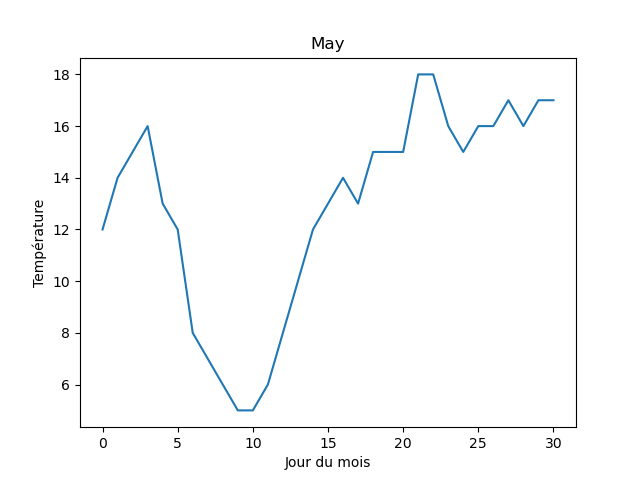

<IPython.core.display.Javascript object>


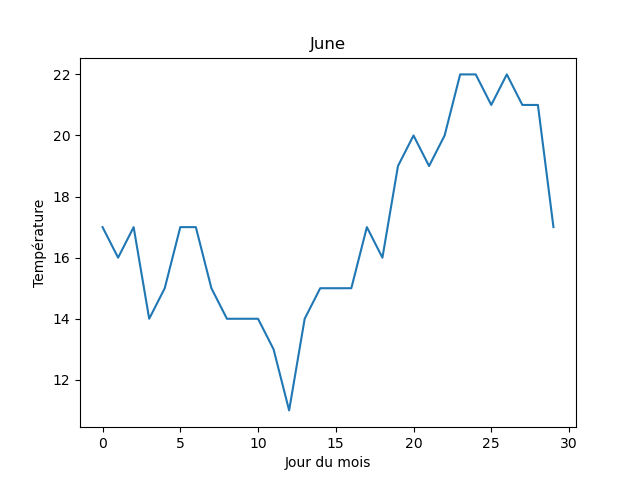

<IPython.core.display.Javascript object>


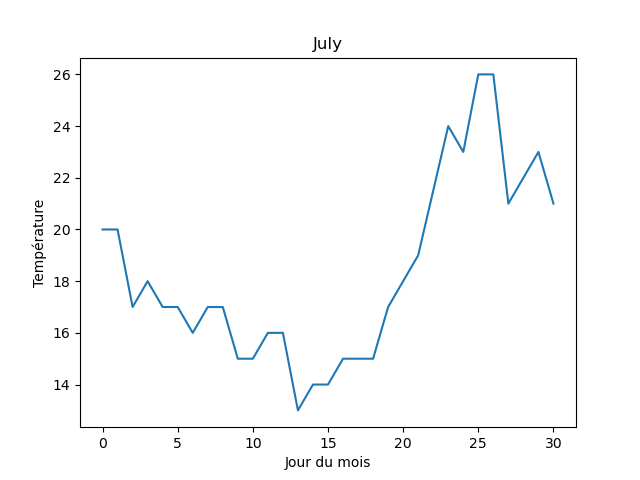

<IPython.core.display.Javascript object>


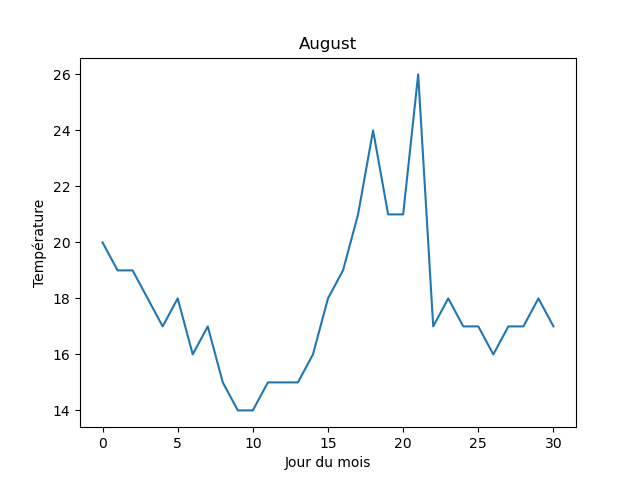

<IPython.core.display.Javascript object>


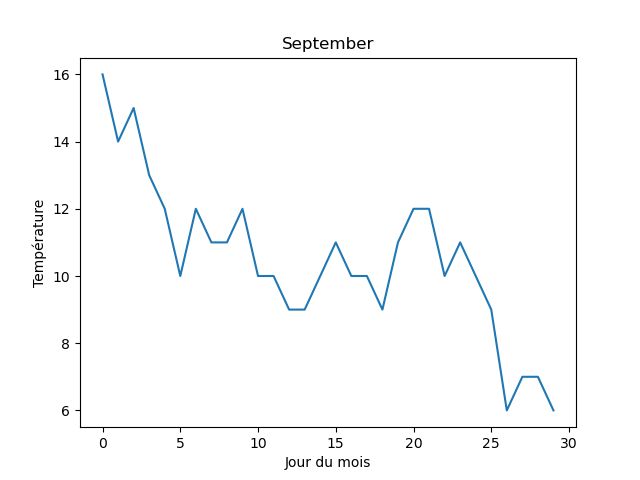

<IPython.core.display.Javascript object>


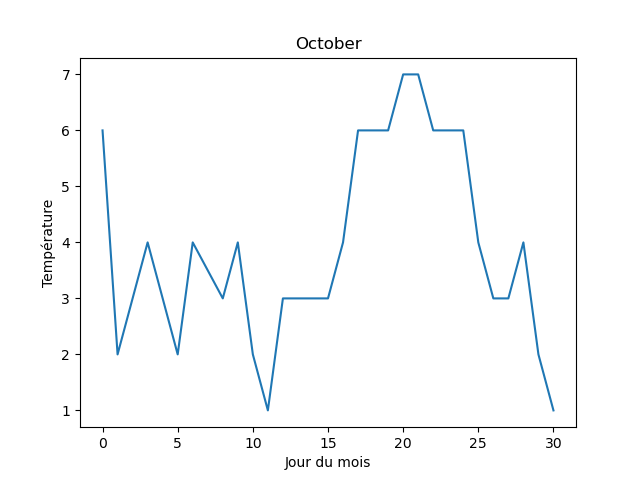

<IPython.core.display.Javascript object>


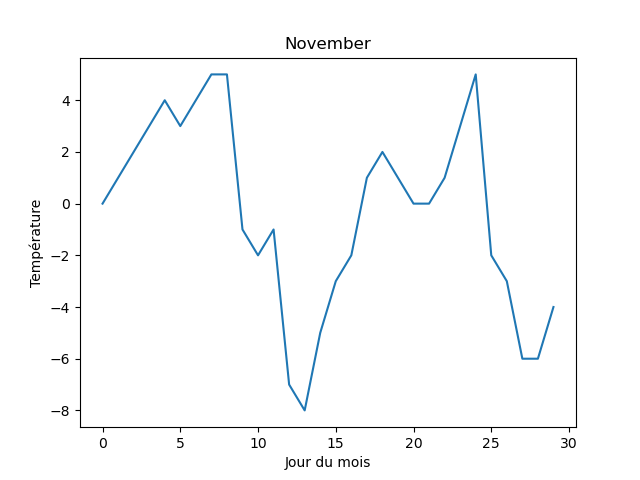

<IPython.core.display.Javascript object>


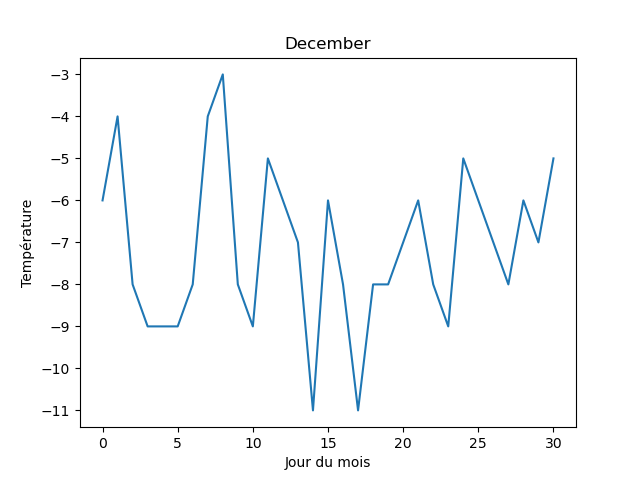

In [21]:
# Affichage de la température par mois via 12 figures

%matplotlib notebook

for month in range(len(temperatures[current_si])):
    plot = plt.figure(month)
    plt.title(calendar.month_name[month + 1])
    plt.plot(temperatures[current_si][month])
    plt.xlabel("Jour du mois")
    plt.ylabel("Température")

plt.show()

<IPython.core.display.Javascript object>


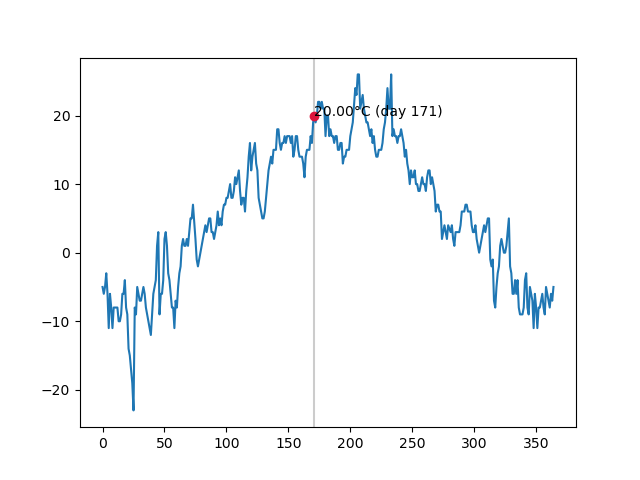

In [22]:
# Affichage de la température à l'année avec un curseur pour lire les valeurs
%matplotlib notebook

fig_range = np.arange(0, 365, 1)
fig, ax = plt.subplots()

cursor = SnaptoCursor(ax, fig_range, flatten(temperatures[current_si]))
cid =  plt.connect('motion_notify_event', cursor.mouse_move)

ax.plot(fig_range, flatten(temperatures[current_si]),)
plt.show()

<IPython.core.display.Javascript object>


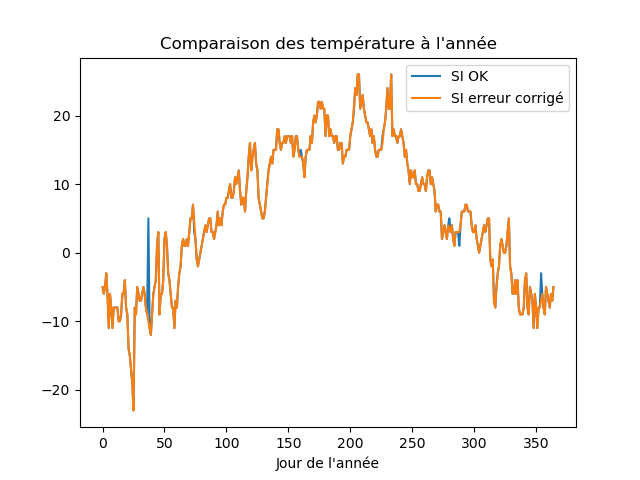

In [23]:
%matplotlib notebook
plot = plt.figure(0)
plt.plot(flatten(temperatures[0]), label = "SI OK")
plt.plot(flatten(temperatures[1]), label = "SI erreur corrigé")
plt.xlabel("Jour de l'année")
plt.title("Comparaison des température à l'année")
plt.legend()
plt.show()

### Traitement sur le fichier Savukoski kirkonkyla.xlsx ###

In [24]:
## Chargement de la page "SI - Erreur" du fichier "Savukoski kirkonkyla.xlsx"

current_si += 1
si_savukoski = pd.read_excel("/home/jovyan/work/data/Savukoski kirkonkyla.xlsx", sheet_name=2)

In [25]:
## Récupération des températures depuis l'excel pour le SI de Savukoski kirkonkyla
indexArray=[]
month = 1
month_temperature=[]
index = 1

temperature_si = []

for row in range(0, 365):
    temperature_value_max = si_savukoski.iloc[row, 6]
    temperature_value_min = si_savukoski.iloc[row, 7]
    # SI la valeur max est nulle, alors on va faire la moyenne entre les valeurs max 
    # du jour précédent et suivant ayant au moins une valeur correcte
    if(np.isnan(temperature_value_max)):
        temperature_value_max = np.average([getNextCorrectValue(si_savukoski, row, 6), getPreviousCorrectValue(si_savukoski, row, 6)])
    # SI la valeur min est nulle, alors on va faire la moyenne entre les valeurs min 
    # du jour précédent et suivant ayant au moins une valeur correcte
    if(np.isnan(temperature_value_min)):
        temperature_value_min = np.average([getNextCorrectValue(si_savukoski, row, 7), getPreviousCorrectValue(si_savukoski, row, 7)])
    
    # On sauvegarde la moyenne entre la température max et la température min.
    temp_avg = round(np.average([temperature_value_min, temperature_value_max]), 2)
    month_temperature.append(temp_avg)
    currentMonth = si_savukoski.iloc[row, 1]
    if currentMonth > month:
        temperature_si.append(month_temperature)
        month_temperature=[]
        month = currentMonth

temperature_si.append(month_temperature)

temperatures.append(temperature_si)

In [26]:
# Calcul des moyennes des températures
temperatures_averages.append(getAveragePerArray(temperatures[current_si]))
print()

# Calcul des écarts-types des températures
temperatures_standard_deviation.append(getStandardDeviationPerArray(temperatures[current_si]))

# Calcul des min et max des températures par mois
min_per_array, max_per_array = getMinAndMaxPerArray(temperatures[current_si])
temperatures_min_per_month.append(min_per_array)
temperatures_max_per_month.append(max_per_array)
print("Min temp {!s} and max temp {!s}".format(min(min_per_array), max(max_per_array)))


Min temp -27.2 and max temp 24.7


<IPython.core.display.Javascript object>


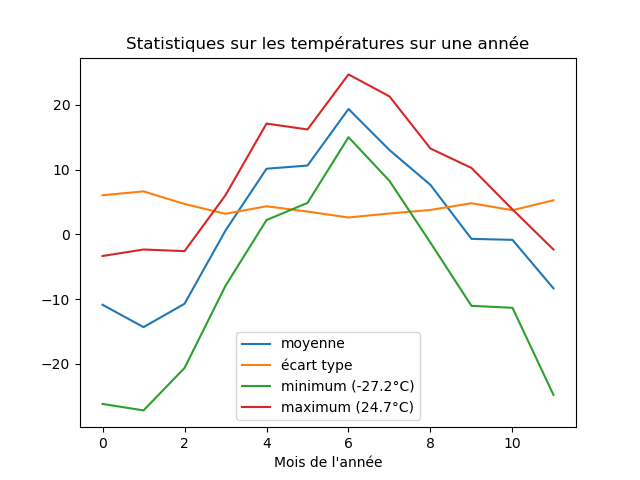

In [27]:
# Affichages des moyennes, des écarts-types et des min-max par mois
# dans un schéma pour que ce soit visuel

%matplotlib notebook

plot = plt.figure(0)
plt.plot(temperatures_averages[current_si], label = "moyenne")
plt.plot(temperatures_standard_deviation[current_si], label = "écart type")
plt.plot(temperatures_min_per_month[current_si], label = "minimum (" + str(min(temperatures_min_per_month[current_si])) + "°C)")
plt.plot(temperatures_max_per_month[current_si], label = "maximum (" + str(max(temperatures_max_per_month[current_si])) + "°C)")
plt.xlabel("Mois de l'année")
plt.title("Statistiques sur les températures sur une année")
plt.legend()
plt.show()

In [28]:
# On compare les écarts

print(calculateDeviation(temperatures_averages[1], temperatures_averages[2]))
print(calculateDeviation(temperatures_standard_deviation[1], temperatures_standard_deviation[2]))
print(calculateDeviation(temperatures_min_per_month[1], temperatures_min_per_month[2]))
print(calculateDeviation(temperatures_max_per_month[1], temperatures_max_per_month[2]))

[0.824, 0.381, 0.116, 13.598, 1.274, 1.601, 0.947, 1.368, 1.376, 5.502, 0.389, 0.854]
[0.732, 0.625, 0.744, 0.979, 0.916, 0.852, 1.357, 0.829, 0.609, 0.353, 0.982, 0.361]
[0.878, 0.441, 0.387, 0.252, 2.273, 2.268, 0.867, 1.697, 4.615, 0.09, 0.705, 0.444]
[0.896, 1.277, 2.692, 2.645, 1.053, 1.358, 1.053, 1.221, 1.208, 0.683, 1.299, 1.277]


On constate que les données ne sont pas cohérentes. Il ne s'agit pas de la même ville.
Selon les données, on est dans un pays du nord de l'europe où il fait en dessous de 0 l'hiver.

### Traitement sur le fichier opendata city_temperature_light.csv.xlsx ###

In [29]:
## Chargement du fichier city_temperature_light.csv.xlsx

si_opendata = pd.read_excel("/home/jovyan/work/data/city_temperature_light.csv.xlsx", sheet_name=0)

In [30]:
temperatures_opendata=[]
opendata_year_country=[]
temperatures_opendata_averages=[]
temperatures_opendata_standard_deviation=[]
temperatures_opendata_min_per_month=[]
temperatures_opendata_max_per_month=[]

In [31]:
current_month_temperatures = []
current_year_temperatures = []
current_month = si_opendata.iloc[1, 4]
current_year = si_opendata.iloc[1, 6]

def fahrenheitToCelsius(value):
    return np.round((value - 32) / 1.8, 2)

# On récupère les données des différentes années du fichier d'open data
for row in range(0,len(si_opendata.index)):
    if si_opendata.iloc[row, 4] != current_month:
        current_year_temperatures.append(current_month_temperatures)
        current_month = si_opendata.iloc[row, 4]
        current_month_temperatures = []
    if si_opendata.iloc[row, 6] != current_year:
        if(len(flatten(current_year_temperatures)) >= 365):
            temperatures_opendata.append(current_year_temperatures)
            opendata_year_country.append([current_year, si_opendata.iloc[row, 3]])
        current_year = si_opendata.iloc[row, 6]
        current_year_temperatures = []
    current_month_temperatures.append(fahrenheitToCelsius(si_opendata.iloc[row, 7]))

current_year_temperatures.append(current_month_temperatures)
if(len(flatten(current_year_temperatures)) >= 365):
    temperatures_opendata.append(current_year_temperatures)
    opendata_year_country.append([current_year, si_opendata.iloc[row, 3]])

In [32]:
# On calcul les moyennes et les écarts types
print(len(temperatures_opendata))
for index in range(0, len(temperatures_opendata)):
    temperatures_opendata_averages.append(getAveragePerArray(temperatures_opendata[index]))
    temperatures_opendata_standard_deviation.append(getStandardDeviationPerArray(temperatures_opendata[index]))

150


In [33]:
# On détermine quel est l'année et la ville qui se rapproche le plus de 1 en comparant les moyennes

best_average_score = 0
best_average_score_index = 0

for index in range(0, len(temperatures_opendata_averages)):
    average_score = np.prod(calculateDeviation(temperatures_opendata_averages[index], temperatures_averages[1]))
    if(np.abs(1 - best_average_score) > np.abs(average_score - 1)):
        best_average_score = average_score
        best_average_score_index = index

print(best_average_score, best_average_score_index, opendata_year_country[best_average_score_index])

0.9445769595118712 148 [2018, 'Stockholm']


<IPython.core.display.Javascript object>


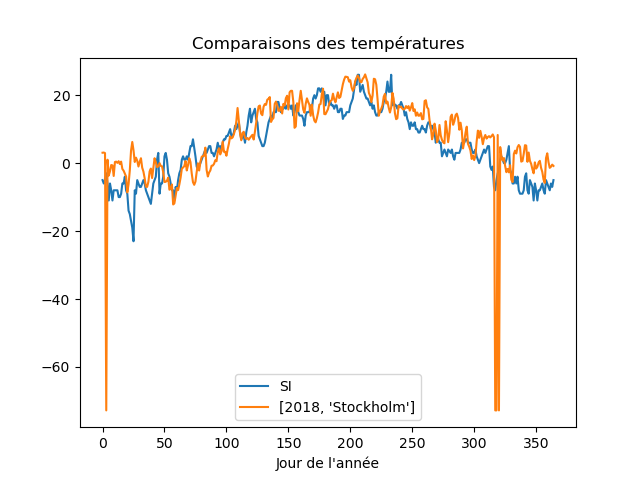

In [34]:
# On affiche les températures du SI et de la ville trouvée
%matplotlib notebook

plot = plt.figure(0)
plt.plot(flatten(temperatures[1]), label = "SI")
plt.plot(flatten(temperatures_opendata[best_average_score_index]), label = opendata_year_country[best_average_score_index])
plt.xlabel("Jour de l'année")
plt.title("Comparaisons des températures")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


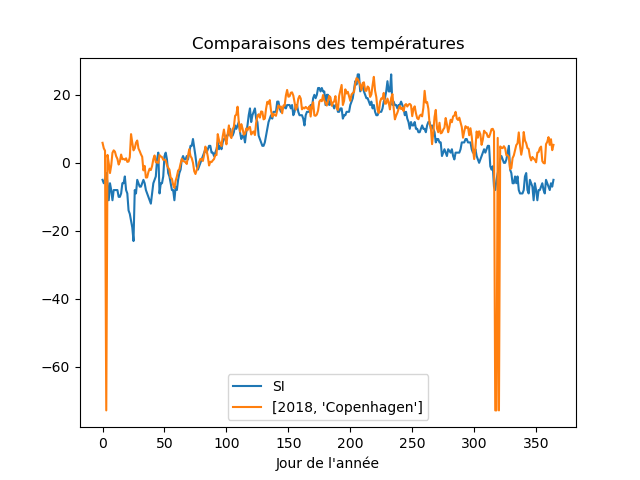

<IPython.core.display.Javascript object>


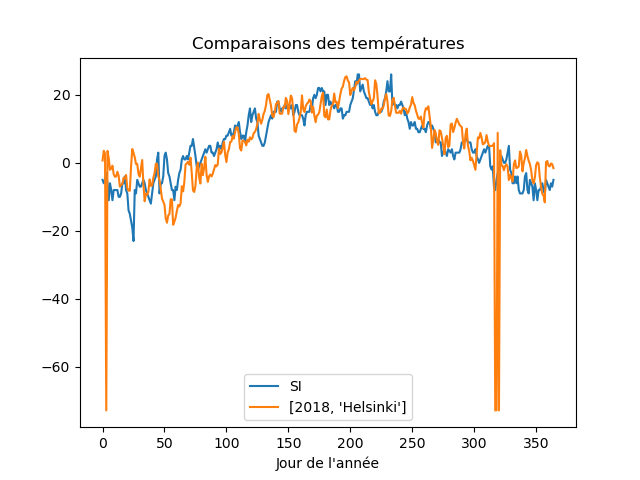

<IPython.core.display.Javascript object>


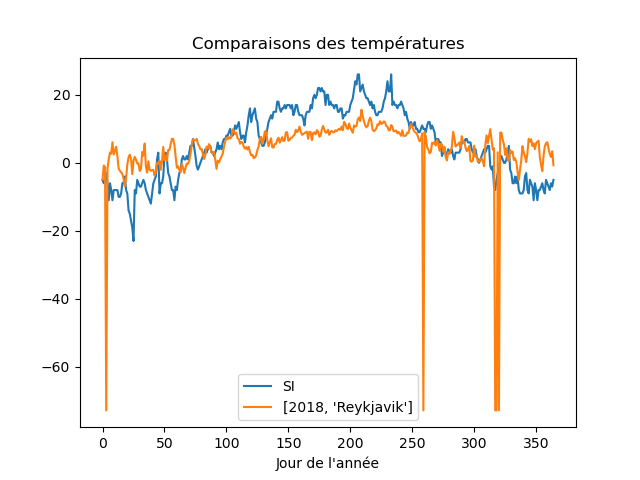

<IPython.core.display.Javascript object>


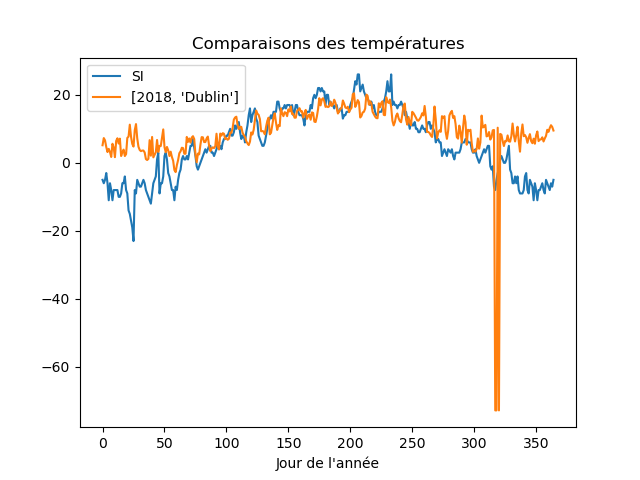

<IPython.core.display.Javascript object>


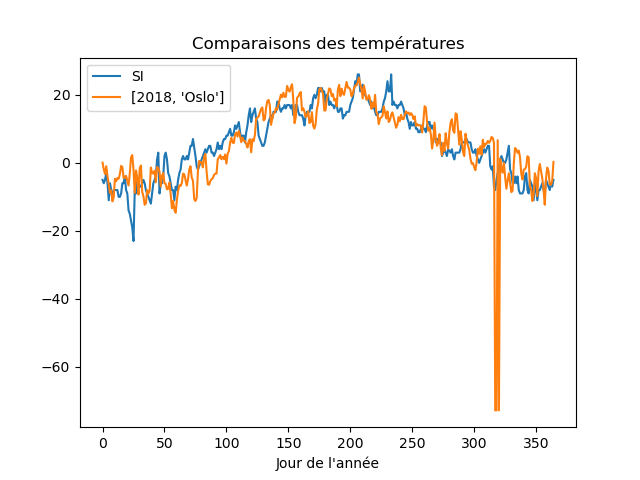

<IPython.core.display.Javascript object>


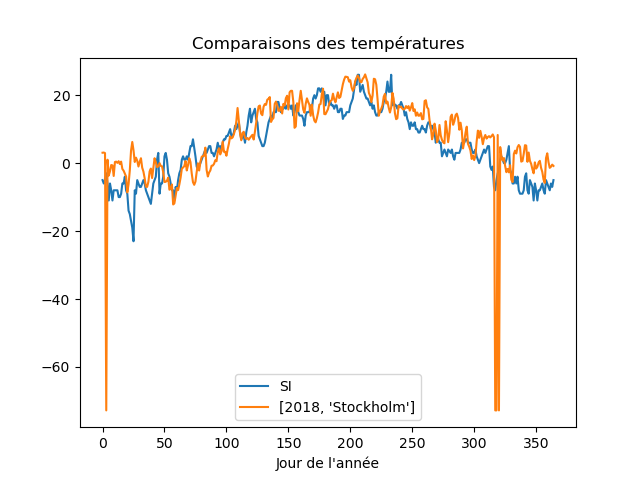

In [35]:
# On affiche les températures du SI et de la ville trouvée
%matplotlib notebook

for index in range(0, len(temperatures_opendata_averages)):
    if opendata_year_country[index][0] == 2018:
        plot = plt.figure(index)
        plt.plot(flatten(temperatures[1]), label = "SI")
        plt.plot(flatten(temperatures_opendata[index]), label = opendata_year_country[index])
        plt.xlabel("Jour de l'année")
        plt.title("Comparaisons des températures")
        plt.legend()
        plt.show()